# Clustering

> Exercising our array programming muscles. We are implementing Mean Shift, which is a good cluster analysis algorithm for data with uniform scale, like survey data where all answers are 1-5. 

Adapted from:
- https://www.youtube.com/watch?v=_xIzPbCgutY&list=PLfYUBJiXbdtRUvTUYpLdfHHp9a58nWVXP&index=4

In [1]:
#| default_exp mean_shift

In [2]:
import math

import matplotlib.pyplot as plt
import torch
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from torch import tensor
from torch.distributions.multivariate_normal import MultivariateNormal

In [3]:
torch.manual_seed(42)

# Norms

- M.A.E. = $|\Delta x | + |\Delta y |$
- M.S.E. = $\Delta x ^2 + \Delta y ^2 = ||v||_2 = \sqrt{|v|} = \sqrt{|v|_2} $
- R.M.S.E. $=\sqrt{\frac{1}{n}\Sigma_{i=0}^n (x_i - \hat{x}_i)^2} = ||v||^2_2 = |v| = |v|_2 $

# Create synthetic data

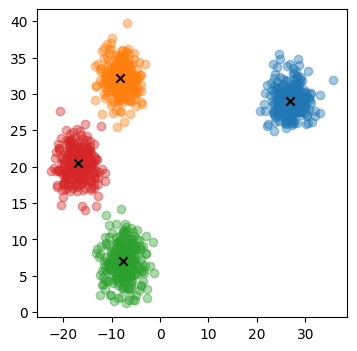

In [4]:
n_clusters = 4
n_samples = 256


def sample(mean):
    covariance = torch.diag(tensor([5.0, 5.0], dtype=torch.float))
    return MultivariateNormal(mean, covariance).sample((n_samples,))


centroids = torch.rand(n_clusters, 2) * 70 - 35
data_by_centroid = [sample(mean) for mean in centroids]
data = torch.cat(data_by_centroid)

fig, ax = plt.subplots(figsize=(4, 4))
for subset in data_by_centroid:
    ax.scatter(*subset.T, alpha=0.4)
ax.scatter(*centroids.T, marker="x", color="black")

# Mean Shift

Neat algorithm that has some unique advantages compared to K-means, because it **does not require setting the number of clusters in advance**. It does, however, require a "bandwidth" parameter and that the clusters have a Gaussian falloff.

The algorithm is as follow:

1. For each point, compute the distance between that point and all other points
2. Reassign each point as the weighted average for each distance with a Gaussian kernel where the variance is the "bandwidth" hyperparameter
3. Repeat until convergence

The bandwidth should be about a third of the data, so in this case its about 25.

[Text(0, 0.5, '$P.D.F.(X)$'), Text(0.5, 0, '$X$')]

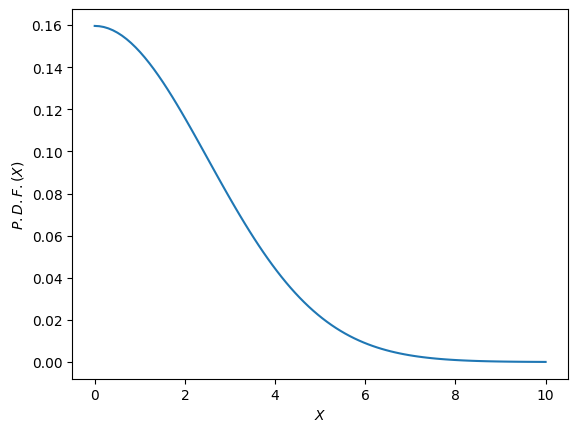

In [5]:
bandwidth = 2.5


def gaussian(x, mu, sig):
    return (
        1.0
        / (math.sqrt(2.0 * torch.pi) * sig)
        * torch.exp(-torch.pow((x - mu) / sig, 2.0) / 2)
    )


def gkernel(x):
    return gaussian(x, mu=0, sig=bandwidth)


x = torch.linspace(0, 10, 100)
y = gkernel(x)

fig, ax = plt.subplots()
ax.plot(x, y)
ax.set(ylabel="$P.D.F.(X)$", xlabel="$X$")

In [6]:
# Manipulate a copy of the data
X = data.clone()

x, *_ = X
x - X

tensor([[ 0.0000,  0.0000],
        [ 4.5407,  1.0199],
        [ 4.5527,  1.6327],
        ...,
        [47.1212,  9.3284],
        [50.7346,  6.5993],
        [44.9273,  8.0535]])

In [7]:
e = ((x - X) ** 2).sum(axis=1).sqrt()
e

tensor([ 0.0000,  4.6538,  4.8366,  ..., 48.0356, 51.1620, 45.6434])

In [8]:
weight = gkernel(e)
weight

tensor([0.1596, 0.0282, 0.0246,  ..., 0.0000, 0.0000, 0.0000])

Now, we have the weights and the data, but we need to combine them.

In [9]:
weight.shape, X.shape

(torch.Size([1024]), torch.Size([1024, 2]))

In [10]:
# This doesn't work
try:
    weighted_rows = weight * X
except RuntimeError as e:
    print(e)

The size of tensor a (1024) must match the size of tensor b (2) at non-singleton dimension 1


In [11]:
# This does, such that the weight is copied to both target
# dimensions by broadcasting
weighted_rows = weight[:, None] * X
weighted_rows

tensor([[4.9080, 4.4652],
        [0.7397, 0.7607],
        [0.6435, 0.6471],
        ...,
        [-0.0000, 0.0000],
        [-0.0000, 0.0000],
        [-0.0000, 0.0000]])

In [12]:
# We need to take a weighted sum, but notice that the weights
# add up to 1200%. We need to normalize.
weight.sum()

tensor(12.1010)

In [13]:
weighted_rows.sum(axis=0) / weight.sum()

tensor([28.6881, 28.6938])

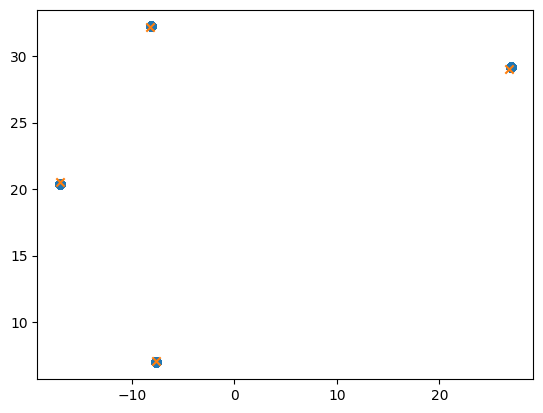

In [14]:
X = data.clone()


def iteration(X):
    for i, x in enumerate(X):
        delta = x - X
        dist = torch.einsum("ij,ij->i", delta, delta).sqrt()
        weight = gkernel(dist)
        weighted_rows = weight[:, None] * X
        X[i, :] = weighted_rows.sum(axis=0) / weight.sum()


for _ in range(5):
    iteration(X)

plt.scatter(*X.T)
plt.scatter(*centroids.T, marker="x")

In [15]:
X = data.clone()


def do_one(d):
    if d:
        iteration(X)
    ax.clear()
    ax.scatter(*X.T)
    ax.scatter(*centroids.T, marker="x")


fig, ax = plt.subplots()
anim = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=True)
plt.close()

HTML(anim.to_jshtml())

# How do we GPU accelerate this?

The issue is this loop:

```python
    for i, x in enumerate(X):
```

This is called the "kernel launching overhead". Let's try to batch this operation

In [16]:
bs = 5

In [17]:
X = data.clone()
miniX = X[:bs]
miniX

tensor([[30.7565, 27.9813],
        [26.2158, 26.9614],
        [26.2037, 26.3486],
        [25.6908, 30.2133],
        [23.2542, 28.5149]])

Now, we need to compute the matrix of distances for each row, which is a $m \times n$ matrix, where $m$ is the `bs` (batch size) and $n$ is the dataset size.

Now, we can't just subtract these off because of the mismatched first dimension.

In [18]:
try:
    X - miniX
except RuntimeError as e:
    print(e)

The size of tensor a (1024) must match the size of tensor b (5) at non-singleton dimension 0


Let's try adding some unit dimensions

In [19]:
X[None, :].shape, miniX[:, None].shape

(torch.Size([1, 1024, 2]), torch.Size([5, 1, 2]))

These dimensions are broadcast compatible because they will result in a copy of the non-batch dimension across the new-unit dimension. Let's see what happens when we do the subtraction now.

In [20]:
delta = X[None, :] - miniX[:, None]
delta.shape

torch.Size([5, 1024, 2])

Now, we can index into the $row_i$ and $row_j$ difference as desired

In [21]:
delta[0, 0, :], delta[0, 1, :]

(tensor([0., 0.]), tensor([-4.5407, -1.0199]))

Now, we just need to collapse this into a $bs \times n$ matrix of distances

In [22]:
dist = (delta**2).sum(axis=2).sqrt()
dist

tensor([[ 0.0000,  4.6538,  4.8366,  ..., 48.0356, 51.1620, 45.6434],
        [ 4.6538,  0.0000,  0.6129,  ..., 43.3835, 46.5297, 40.9945],
        [ 4.8366,  0.6129,  0.0000,  ..., 43.2585, 46.4482, 40.8819],
        [ 5.5356,  3.2940,  3.8986,  ..., 43.6154, 46.5149, 41.1672],
        [ 7.5212,  3.3443,  3.6595,  ..., 40.8279, 43.8168, 38.3975]])

Alternately, as an `einsum`:

In [23]:
torch.einsum("ijk,ijk->ij", delta, delta).sqrt()

tensor([[ 0.0000,  4.6538,  4.8366,  ..., 48.0356, 51.1620, 45.6434],
        [ 4.6538,  0.0000,  0.6129,  ..., 43.3835, 46.5297, 40.9945],
        [ 4.8366,  0.6129,  0.0000,  ..., 43.2585, 46.4482, 40.8819],
        [ 5.5356,  3.2940,  3.8986,  ..., 43.6154, 46.5149, 41.1672],
        [ 7.5212,  3.3443,  3.6595,  ..., 40.8279, 43.8168, 38.3975]])

In [24]:
weights = gkernel(dist)
weights

tensor([[0.1596, 0.0282, 0.0246,  ..., 0.0000, 0.0000, 0.0000],
        [0.0282, 0.1596, 0.1549,  ..., 0.0000, 0.0000, 0.0000],
        [0.0246, 0.1549, 0.1596,  ..., 0.0000, 0.0000, 0.0000],
        [0.0138, 0.0670, 0.0473,  ..., 0.0000, 0.0000, 0.0000],
        [0.0017, 0.0652, 0.0547,  ..., 0.0000, 0.0000, 0.0000]])

In [25]:
weights.shape, X.shape

(torch.Size([5, 1024]), torch.Size([1024, 2]))

In [26]:
norm_constant = 1 / weights.sum(axis=1)
# Note that we need to broadcast the normalization over the X and Y dimensions
reweighted = (weights @ X) * norm_constant[:, None]
reweighted

tensor([[28.6881, 28.6938],
        [26.6096, 28.3607],
        [26.5901, 28.1598],
        [26.3962, 29.4940],
        [25.2566, 28.8559]])

In [27]:
def mean_shift_batch(data, bs=512, iterations=5):
    X = data.clone()
    n = len(X)
    for _ in range(iterations):
        for i in range(0, n, bs):
            batch_idxs = slice(i, min((i + bs, n)))
            batch = X[batch_idxs]
            delta = X[None, :] - batch[:, None]
            weight = gkernel(torch.einsum("ijk,ijk->ij", delta, delta).sqrt())
            norm = 1 / weight.sum(axis=1)
            X[batch_idxs] = (weight @ X) * norm[:, None]
    return X

In [28]:
DEVICE = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

In [29]:
data_acc = data.to(DEVICE)

In [30]:
mean_shift_batch(data_acc)

tensor([[ 26.9455,  29.1479],
        [ 26.9455,  29.1479],
        [ 26.9455,  29.1479],
        ...,
        [-16.9937,  20.3887],
        [-16.9937,  20.3887],
        [-16.9937,  20.3887]], device='mps:0')

## Homework

Implement DBSCAN

In [31]:
X = data.clone()

In [32]:
n, _ = X.shape

In [33]:
eps = 2.5
min_points = 25

In [34]:
norms = torch.pow(X[None, :] - X[:, None], 2).sum(axis=2).sqrt()
norms

tensor([[ 0.0000,  4.6538,  4.8366,  ..., 48.0356, 51.1620, 45.6434],
        [ 4.6538,  0.0000,  0.6129,  ..., 43.3835, 46.5297, 40.9945],
        [ 4.8366,  0.6129,  0.0000,  ..., 43.2585, 46.4482, 40.8819],
        ...,
        [48.0356, 43.3835, 43.2585,  ...,  0.0000,  4.5282,  2.5374],
        [51.1620, 46.5297, 46.4482,  ...,  4.5282,  0.0000,  5.9866],
        [45.6434, 40.9945, 40.8819,  ...,  2.5374,  5.9866,  0.0000]])

In [35]:
cluster_assignment = torch.zeros(n)
cluster_assignment

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [36]:
from functools import lru_cache
from typing import Optional


class DontReassignCluster(Exception):
    ...


@lru_cache
def core_point_neighbords(point_idx) -> Optional:
    dists = norms[point_idx, :]
    neighboring_point_idxs = dists < eps
    if neighboring_point_idxs.sum() > min_points:
        return neighboring_point_idxs


def assign_cluster(cluster_id, point_idx):
    if cluster_assignment[point_idx]:
        raise DontReassignCluster

    # First, assign point to cluster
    cluster_assignment[point_idx] = cluster_id

    # Then, if it is a core point, recursively assign the neighbors
    dists = norms[point_idx, :]
    neighboring_point_idxs = core_point_neighbords(point_idx)
    if neighboring_point_idxs is not None:
        for i, is_neighbor in enumerate(neighboring_point_idxs):
            if is_neighbor:
                try:
                    assign_cluster(cluster_id, i)
                except DontReassignCluster:
                    continue


current_cluster_id = 1

for point_idx in range(n):
    if core_point_neighbords(point_idx) is not None:
        try:
            assign_cluster(current_cluster_id, point_idx)
        except DontReassignCluster:
            continue
        else:
            current_cluster_id += 1

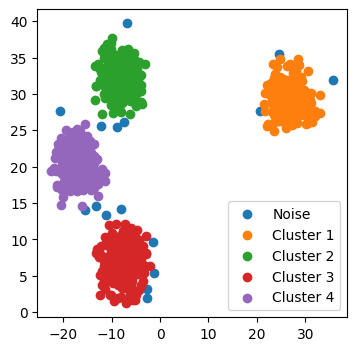

In [37]:
fig, ax = plt.subplots(figsize=(4, 4))
for cluster in cluster_assignment.unique():
    ax.scatter(
        *X[cluster_assignment == cluster, :].T,
        label=f"Cluster {int(cluster)}" if cluster else "Noise",
    )
ax.legend();

In [38]:
#| hide
import nbdev

nbdev.nbdev_export()